Importing Modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import matplotlib
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import os
import time
import numpy as np
import argparse
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
matplotlib.style.use('ggplot')
import sys, importlib as impL
sys.path.insert(1,'/home/wsubuntu/GitHub/keyhandshapediscovery')
import helperFuncs as funcH
import pandas as pd

EXPERIMENT_ID = 25
LOSS_TYPE='cre'
LOSS_REDUCTION='mean' #'sum','batchmean'
SIGMOID_ACT=True
MSE_PLUS_MINUS='+'
APPLY_SPARSITY_TO='bottleneck' #all

In [2]:
def calc_bottleneck_acc(bottleneck_vec, lab_vec):
    pred_vec = np.argmax(bottleneck_vec.T, axis=0).T.squeeze()
    centroid_info_pdf = funcH.get_cluster_centroids(bottleneck_vec, pred_vec, kluster_centers=None, verbose=0)
    _confMat_preds, kluster2Classes, kr_pdf, weightedPurity, cnmxh_perc = funcH.countPredictionsForConfusionMat(lab_vec, pred_vec, centroid_info_pdf=centroid_info_pdf, labelNames=None)
    sampleCount = np.sum(np.sum(_confMat_preds))
    acc = 100 * np.sum(np.diag(_confMat_preds)) / sampleCount
    bmx, bmn = np.max(bottleneck_vec), np.min(bottleneck_vec)
    return acc, bmx, bmn

funcH.setPandasDisplayOpts()

Constructing the Argument Parsers

In [3]:
#ap = argparse.ArgumentParser()
#ap.add_argument('-e', '--epochs', type=int, default=10, help='number of epochs to train our network for')
#ap.add_argument('-l', '--reg_param', type=float, default=0.001, help='regularization parameter `lambda`')
#ap.add_argument('-sc', '--add_sparse', type=str, default='yes', help='whether to add sparsity contraint or not')
#args = vars(ap.parse_args())
epochs = 100  # args['epochs']
reg_param = 0.001  # args['reg_param']
add_sparsity = 'yes'  # args['add_sparse']
learning_rate = 1e-4
batch_size = 32
print(f"Add sparsity regularization: {add_sparsity}")

Add sparsity regularization: yes


here I will change the data loader per my need

In [4]:
# get the computation device
def get_device():
    return 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = get_device()
print(device)

cpu


In [5]:
# image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

FOLDERS = {
    "data": '/media/wsubuntu/SSD_Data/DataPath',
    "experiment": '/media/wsubuntu/SSD_Data/vaesae_experiments/sparse_torch_ae_ws_' + str(EXPERIMENT_ID).zfill(3),
}
FOLDERS["model_save"] = os.path.join(FOLDERS["experiment"], "model")
FOLDERS["decoder_image_path_tr"] = os.path.join(FOLDERS["experiment"], "output_images_tr")
FOLDERS["decoder_image_path_va"] = os.path.join(FOLDERS["experiment"], "output_images_va")
funcH.createDirIfNotExist(FOLDERS["model_save"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_tr"])
funcH.createDirIfNotExist(FOLDERS["decoder_image_path_va"])

trainset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root=FOLDERS["data"],
    train=False,
    download=True,
    transform=transform
)
 
# trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=batch_size,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=batch_size, 
    shuffle=False
)

In [6]:
# define the autoencoder model
class SparseAutoencoder(nn.Module):
    def __init__(self, loss_type):
        super(SparseAutoencoder, self).__init__()
 
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
 
        # decoder 
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
        
        self.loss_type=loss_type
        self.device = get_device()

    def encode(self, x):
        # encoding
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        bottleneck = F.relu(self.enc5(x))  
        return bottleneck
        
    def decode(self, bottleneck):
        # decoding
        x = F.relu(self.dec1(bottleneck))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x)) 
        return x
        
    def forward(self, x):
        bottleneck = self.encode(x)
        x = self.decode(bottleneck)
        return x, bottleneck

model = SparseAutoencoder(loss_type=LOSS_TYPE).to(device)

In [7]:
# the loss function
criterion = nn.MSELoss()
# the optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# get the layers as a list
model_children = list(model.children())
[print(i) for i in model_children]

Linear(in_features=784, out_features=256, bias=True)
Linear(in_features=256, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=16, bias=True)
Linear(in_features=16, out_features=32, bias=True)
Linear(in_features=32, out_features=64, bias=True)
Linear(in_features=64, out_features=128, bias=True)
Linear(in_features=128, out_features=256, bias=True)
Linear(in_features=256, out_features=784, bias=True)


[None, None, None, None, None, None, None, None, None, None]

In [9]:
def loss_l1(bottleneck):
    return torch.mean(torch.abs(bottleneck))

def loss_l2(bottleneck):
    return torch.mean(torch.pow(bottleneck, torch.tensor(2.0).to(device))).sqrt()

def kl_divergence(bottleneck, reduction):
    rho = 0.05
    bottleneck = torch.mean(torch.sigmoid(bottleneck), 1)  # sigmoid because we need the probability distributions
    rho = torch.tensor([rho] * len(bottleneck)).to(device)
    loss_ret_1 = torch.nn.functional.kl_div(bottleneck, rho, reduction=reduction)
    # torch.sum(rho * torch.log(rho / bottleneck) + (1 - rho) * torch.log((1 - rho) / (1 - bottleneck)))
    return loss_ret_1

def loss_crossentropy(bottleneck, sigmoidAct, reduction):
    loss_fun = torch.nn.CrossEntropyLoss(reduction=reduction)
    if sigmoidAct:
        bt = torch.sigmoid(bottleneck)  # sigmoid because we need the probability distributions
    _, preds = torch.max(bt, 1)
    loss_ret_1 = loss_fun(bt, preds)    
    return loss_ret_1

In [10]:
# define the sparse loss function
def sparse_loss(autoencoder, images, print_info, loss_type):
    loss = 0
    values = images
    for i in range(len(model_children)):
        values = F.relu((model_children[i](values)))
        #if print_info:
            #print(i, ' shape=', values.shape)
        if loss_type=='l1':
            loss += loss_l1(values)
        if loss_type=='l2':
            loss += loss_l2(values)
        if loss_type=='kl':
            loss += kl_divergence(values, reduction=LOSS_REDUCTION)
        if loss_type=='cre':
            loss += loss_crossentropy(values, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
        if print_info:
            print(loss_type,loss)
    return loss

def sparse_loss_bottleneck(bottleneck, print_info, loss_type):
    loss = 0
    #if print_info:
        #print(i, ' shape=', values.shape)
    if loss_type=='l1':
        loss += loss_l1(bottleneck)
    if loss_type=='l2':
        loss += loss_l2(bottleneck)
    if loss_type=='kl':
        loss += kl_divergence(bottleneck, reduction=LOSS_REDUCTION)
    if loss_type=='cre':
        loss += loss_crossentropy(bottleneck, sigmoidAct=SIGMOID_ACT, reduction=LOSS_REDUCTION)
    if print_info:
        print(loss_type,loss)
    return loss

In [11]:
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

# define the training function
def fit(model, dataloader, epoch, print_losses_fit):
    print('TrEpoch({:03d}) - '.format(epoch), end='')
    model.train()
    running_loss = 0.0
    
    lab_vec = []
    bottleneck_vec = []
    sparsity_loss_sum = 0
    mse_sum = 0
       
    for data in dataloader:
        img, lb = data
        lab_vec.append(lb)
        
        img = img.to(device)
        img = img.view(img.size(0), -1)
        optimizer.zero_grad()
        outputs, bottleneck = model(img)
        bottleneck_vec.append(bottleneck)
        mse_loss = criterion(outputs, img)
        mse_sum += mse_loss.item()
        #if print_losses_fit:
            #print("mse_loss:", mse_loss.to('cpu'))
            #print("bottleneck:", bottleneck.to('cpu'))
        if add_sparsity == 'yes':
            if APPLY_SPARSITY_TO=='all':
                sp_loss = sparse_loss(model, img, print_losses_fit, model.loss_type)
            elif APPLY_SPARSITY_TO=='bottleneck': #all
                sp_loss = sparse_loss_bottleneck(bottleneck, print_losses_fit, model.loss_type)
            else:
                os.exit(4)
                
            sparsity_loss_sum += sp_loss.item()
            
            # add the sparsity penalty
            if print_losses_fit:
                print("sp_loss:", sparsity_loss_sum)
                
            if MSE_PLUS_MINUS=='-':
                loss = mse_loss - reg_param * sp_loss
            elif MSE_PLUS_MINUS=='+':
                loss = mse_loss + reg_param * sp_loss
        else:
            loss = mse_loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        print_losses_fit = False
    
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)
    #print("tr bottleneck accuracy=", acc, ", max=", bmx, ", min=", bmn, ", sparsity_loss_sum=", sparsity_loss_sum)
  
    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, mse_sum, sparsity_loss_sum, running_loss]]), columns=['acc','bmx','bmn','mse','spr','run'])
    #print(df.iloc[0]['mse']) #'acc','bmx','bmn','mse','spr','run'
    print("\n",result_df)
    if epoch % 2 == 0:
        difn = os.path.join(FOLDERS["decoder_image_path_tr"], "train"+str(epoch).zfill(3)+".png")
        save_decoded_image(outputs.cpu().data, difn)
    return result_df

In [12]:
# define the validation function
def validate(model, dataloader, epoch, print_losses_fit):
    print('ValEpoch({:03d}) - '.format(epoch), end='')
    model.eval()
    running_loss = 0.0
    lab_vec = []
    bottleneck_vec = []
    with torch.no_grad():
        for data in dataloader:
            img, lb = data
            lab_vec.append(lb)
            img = img.to(device)
            img = img.view(img.size(0), -1)
            outputs, bottleneck = model(img)
            bottleneck_vec.append(bottleneck)
            loss = criterion(outputs, img)
            running_loss += loss.item()
    # save the reconstructed images every 5 epochs
    lab_vec = np.asarray(torch.cat(lab_vec).to(torch.device('cpu')))
    bottleneck_vec = np.asarray(torch.cat(bottleneck_vec).to(torch.device('cpu')).detach().numpy())
    acc, bmx, bmn = calc_bottleneck_acc(bottleneck_vec, lab_vec)

    result_df = pd.DataFrame(np.array([[acc, bmx, bmn, running_loss]]), columns=['acc','bmx','bmn','run'])
    print("\n",result_df)
    
    if epoch % 2 == 0:
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        difn = os.path.join(FOLDERS["decoder_image_path_va"], "reconstruction"+str(epoch).zfill(3)+".png")
        save_image(outputs, difn)
    return result_df

In [13]:
# train and validate the autoencoder neural network
start = time.time()
print_losses_fit = True

train_loss = []
trn_spars_loss = []
trn_bot_acc = []
val_loss = []
val_bot_acc = []

result_df_tr_all = pd.DataFrame(columns=['acc','bmx','bmn','mse','spr','run'])
result_df_va_all = pd.DataFrame(columns=['acc','bmx','bmn','run'])

print("stae_ws05 :: ")
print("EXPERIMENT_ID: ", EXPERIMENT_ID)
print("LOSS_TYPE : ", LOSS_TYPE)
print("LOSS_REDUCTION : ", LOSS_REDUCTION)
print("SIGMOID_ACT : ", SIGMOID_ACT)
print("APPLY_SPARSITY_TO : ", APPLY_SPARSITY_TO)
print("total loss = mse_loss " + MSE_PLUS_MINUS + " reg_param("+ str(reg_param) +") * sp_loss")

for epoch in range(epochs):
    print(f"*****\n Epoch {epoch} of {epochs}")
    result_df_tr = fit(model, trainloader, epoch, print_losses_fit)
    result_df_va = validate(model, testloader, epoch, print_losses_fit)
    print_losses_fit = epoch%5==0 and epoch>0
    result_df_tr_all = result_df_tr_all.append(result_df_tr, ignore_index=True)
    result_df_va_all = result_df_va_all.append(result_df_va, ignore_index=True)
    
end = time.time()
 
print(f"{(end-start)/60:.3} minutes")
# save the trained model

mofn = os.path.join(FOLDERS["model_save"], "sparse_ae_"+str(epoch).zfill(3)+".pth")
torch.save(model.state_dict(), mofn)

stae_ws05 :: 
EXPERIMENT_ID:  25
LOSS_TYPE :  cre
LOSS_REDUCTION :  mean
SIGMOID_ACT :  True
APPLY_SPARSITY_TO :  bottleneck
total loss = mse_loss + reg_param(0.001) * sp_loss
*****
 Epoch 0 of 100
TrEpoch(000) - cre tensor(2.7379, grad_fn=<AddBackward0>)
sp_loss: 2.7379026412963867

       acc     bmx  bmn      mse       spr      run
0  18.192  24.167  0.0  142.971  4741.521  147.712
ValEpoch(000) - 
     acc     bmx  bmn     run
0  22.4  24.186  0.0  17.047
*****
 Epoch 1 of 100
TrEpoch(001) - 
       acc     bmx  bmn     mse       spr      run
0  19.623  25.573  0.0  98.415  4722.188  103.137
ValEpoch(001) - 
     acc     bmx  bmn     run
0  27.5  25.073  0.0  15.912
*****
 Epoch 2 of 100
TrEpoch(002) - 
       acc     bmx  bmn     mse       spr     run
0  25.188  26.381  0.0  92.382  4696.507  97.078
ValEpoch(002) - 
      acc     bmx  bmn     run
0  25.22  25.207  0.0  14.981
*****
 Epoch 3 of 100
TrEpoch(003) - 
       acc     bmx  bmn     mse       spr    run
0  19.943  26.546  

ValEpoch(035) - 
      acc     bmx  bmn    run
0  22.94  26.833  0.0  6.519
*****
 Epoch 36 of 100
TrEpoch(036) - cre tensor(2.5162, grad_fn=<AddBackward0>)
sp_loss: 2.516214370727539

       acc    bmx  bmn     mse       spr     run
0  23.485  27.16  0.0  38.585  4719.133  43.304
ValEpoch(036) - 
      acc     bmx  bmn    run
0  23.05  26.461  0.0  6.502
*****
 Epoch 37 of 100
TrEpoch(037) - 
       acc     bmx  bmn     mse       spr     run
0  23.472  26.939  0.0  38.409  4718.378  43.127
ValEpoch(037) - 
      acc     bmx  bmn   run
0  23.08  26.111  0.0  6.47
*****
 Epoch 38 of 100
TrEpoch(038) - 
       acc     bmx  bmn     mse       spr     run
0  23.133  26.711  0.0  38.253  4717.577  42.971
ValEpoch(038) - 
      acc     bmx  bmn   run
0  23.05  26.069  0.0  6.45
*****
 Epoch 39 of 100
TrEpoch(039) - 
       acc     bmx  bmn     mse       spr     run
0  23.475  26.667  0.0  38.106  4717.196  42.823
ValEpoch(039) - 
     acc     bmx  bmn    run
0  23.1  25.609  0.0  6.424
*****


ValEpoch(071) - 
      acc     bmx  bmn    run
0  19.77  21.465  0.0  5.704
*****
 Epoch 72 of 100
TrEpoch(072) - 
       acc    bmx  bmn     mse       spr     run
0  23.058  21.96  0.0  33.413  4703.372  38.117
ValEpoch(072) - 
      acc     bmx  bmn    run
0  19.64  21.298  0.0  5.693
*****
 Epoch 73 of 100
TrEpoch(073) - 
       acc     bmx  bmn     mse      spr     run
0  23.053  21.702  0.0  33.342  4703.78  38.046
ValEpoch(073) - 
      acc     bmx  bmn    run
0  19.78  21.231  0.0  5.667
*****
 Epoch 74 of 100
TrEpoch(074) - 
       acc    bmx  bmn     mse       spr     run
0  23.022  21.61  0.0  33.073  4704.327  37.777
ValEpoch(074) - 
      acc     bmx  bmn    run
0  19.82  21.067  0.0  5.629
*****
 Epoch 75 of 100
TrEpoch(075) - 
       acc     bmx  bmn     mse       spr     run
0  23.018  21.553  0.0  32.773  4704.608  37.478
ValEpoch(075) - 
      acc     bmx  bmn    run
0  19.79  21.028  0.0  5.584
*****
 Epoch 76 of 100
TrEpoch(076) - cre tensor(2.5066, grad_fn=<AddBackw

In [14]:
print(result_df_tr_all)

       acc     bmx  bmn      mse       spr      run
0   18.192  24.167  0.0  142.971  4741.521  147.712
1   19.623  25.573  0.0   98.415  4722.188  103.137
2   25.188  26.381  0.0   92.382  4696.507   97.078
3   19.943  26.546  0.0   81.707  4702.561   86.410
4   20.617  26.328  0.0   71.156  4707.857   75.864
5   19.935  27.065  0.0   66.064  4712.251   70.776
6   18.722  28.913  0.0   62.240  4720.187   66.960
7   19.043  29.537  0.0   59.045  4721.393   63.766
8   17.957  29.591  0.0   56.103  4718.357   60.821
9   21.963  29.409  0.0   54.494  4714.881   59.209
10  18.708  29.452  0.0   53.277  4713.439   57.991
11  20.732  30.470  0.0   50.836  4714.626   55.551
12  21.172  31.069  0.0   49.621  4721.218   54.342
13  18.338  31.491  0.0   48.689  4727.454   53.416
14  22.425  31.270  0.0   47.531  4729.299   52.260
15  22.445  31.075  0.0   46.688  4729.261   51.417
16  22.560  31.075  0.0   45.982  4729.379   50.711
17  22.553  30.990  0.0   45.560  4730.359   50.290
18  22.648  

In [15]:
print(result_df_va_all)

      acc     bmx  bmn     run
0   22.40  24.186  0.0  17.047
1   27.50  25.073  0.0  15.912
2   25.22  25.207  0.0  14.981
3   19.33  25.749  0.0  12.524
4   20.72  25.688  0.0  11.312
5   19.94  26.959  0.0  10.654
6   22.29  28.434  0.0  10.196
7   17.30  28.605  0.0   9.667
8   18.40  29.060  0.0   9.224
9   18.84  28.906  0.0   9.045
10  18.38  28.908  0.0   8.648
11  17.80  29.716  0.0   8.431
12  19.99  30.172  0.0   8.226
13  19.99  30.358  0.0   8.107
14  21.40  30.209  0.0   7.888
15  21.98  30.041  0.0   7.754
16  22.04  30.036  0.0   7.698
17  22.21  30.289  0.0   7.639
18  19.78  30.060  0.0   7.544
19  19.81  29.862  0.0   7.417
20  22.86  29.819  0.0   7.249
21  19.96  29.433  0.0   7.230
22  19.86  29.251  0.0   7.133
23  19.89  29.039  0.0   7.081
24  19.85  28.594  0.0   7.041
25  19.84  28.286  0.0   6.925
26  19.88  28.205  0.0   6.885
27  19.77  27.968  0.0   6.869
28  19.73  27.622  0.0   6.817
29  23.29  27.702  0.0   6.750
30  22.95  27.465  0.0   6.725
31  22.9

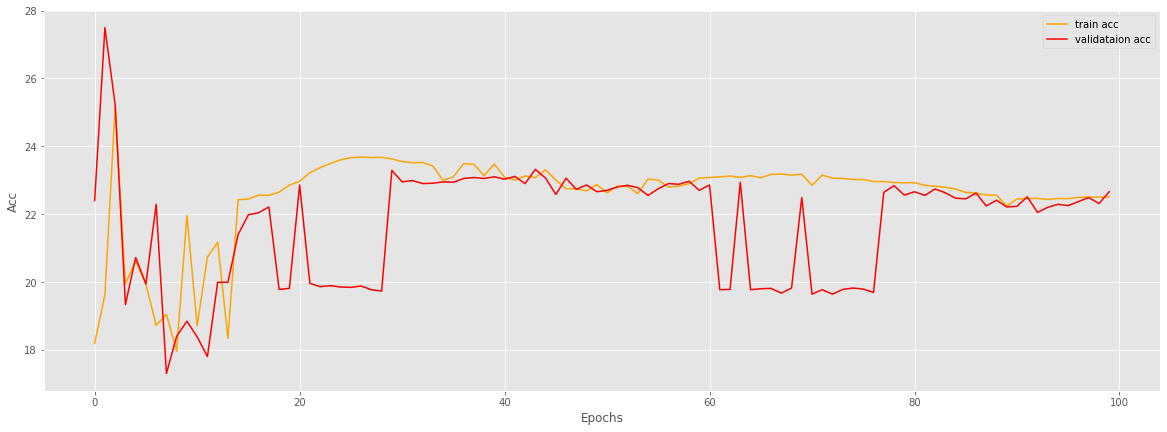

Max tr acc =  25.188333333333333
Max va acc =  27.5


In [16]:
tr_acc = result_df_tr_all.values[:,0].squeeze()
va_acc = result_df_va_all.values[:,0].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_acc, color='orange', label='train acc')
plt.plot(va_acc, color='red', label='validataion acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()
print("Max tr acc = ", np.max(tr_acc))
print("Max va acc = ", np.max(va_acc))

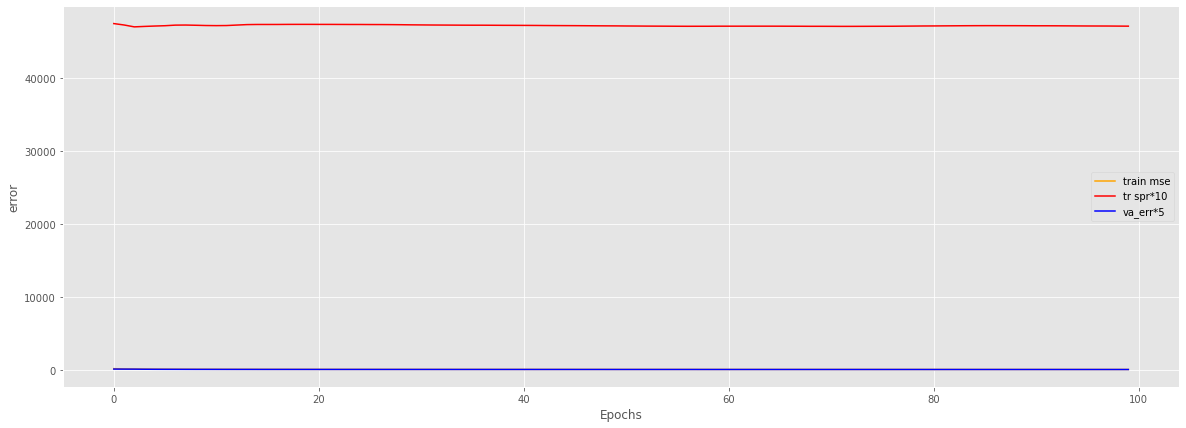

In [17]:
tr_mse = result_df_tr_all.values[:,3].squeeze()
tr_spr_50 = 10*result_df_tr_all.values[:,4].squeeze()
va_err = 5*result_df_va_all.values[:,-1].squeeze()
plt.figure(figsize=(20, 7))
plt.plot(tr_mse, color='orange', label='train mse')
plt.plot(tr_spr_50, color='red', label='tr spr*10')
plt.plot(va_err, color='blue', label='va_err*5')
plt.xlabel('Epochs')
plt.ylabel('error')
plt.legend()
plt.show()